In [7]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from pydicom.dataset import Dataset, FileDataset
from pydicom.sequence import Sequence
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [65]:
folder_path = r"C:\Users\david\OneDrive\Documents\GitHub\General\DICOM files"
dicom_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.dcm')]

dicom_slices = []
for file in dicom_files:
    file_path = os.path.join(folder_path, file)
    ds = pydicom.dcmread(file_path)
    dicom_slices.append(ds)

print(f"Loaded {len(dicom_slices)} DICOM files.")

Loaded 169 DICOM files.


In [64]:
# Load the middle slice for demonstration
middle_index = len(dicom_files) // 2
middle_slice_path = os.path.join(folder_path, dicom_files[middle_index])
ct_slice = pydicom.dcmread(middle_slice_path)

print(f"Patient ID: {ct_slice.PatientID}")
print(f"Modality: {ct_slice.Modality}")
print(f"Slice Location: {ct_slice.SliceLocation}")
print(f"Pixel Spacing: {ct_slice.PixelSpacing}")

Patient ID: ZZ_DD_TEST1
Modality: CT
Slice Location: 115.000
Pixel Spacing: [0.976562, 0.976562]


In [56]:
def get_hu_values(ct_slice):
    # Get pixel values and convert to Hounsfield Units (HU)
    pixel_array = ct_slice.pixel_array
    intercept = ct_slice.RescaleIntercept
    slope = ct_slice.RescaleSlope
    hu_values = pixel_array * slope + intercept
    return hu_values

# ...existing code...
hu_image = get_hu_values(ct_slice)
print(hu_image)
print(hu_image.size)

# Save HU values to a text file
np.savetxt("hu_image.txt", hu_image, fmt="%.2f")
# ...existing code...

[[-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 ...
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]
 [-3024. -3024. -3024. ... -3024. -3024. -3024.]]
262144


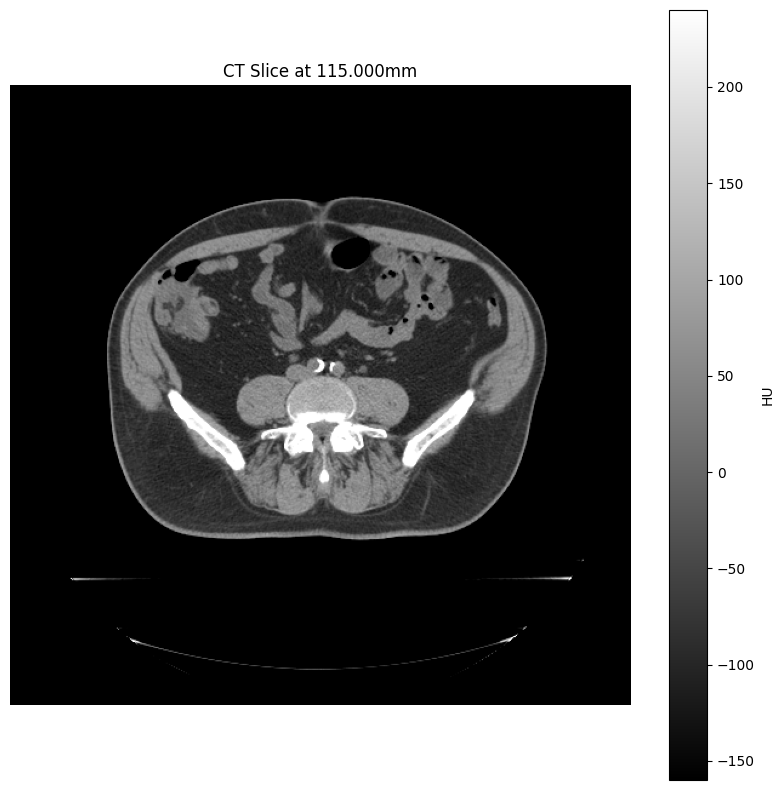

In [63]:
# Set window/level for better visualization (lung window)
window_center = 40  # Center of the window in HU
window_width = 400   # Width of the window in HU
min_value = window_center - window_width/2
max_value = window_center + window_width/2
hu_image_windowed = np.clip(hu_image, min_value, max_value)

# Common window/level presets:
# - Lung: -600/1500 (shows air-filled structures)
# - Soft tissue: 40/400 (optimal for organs)
# - Bone: 500/2000 (best for visualizing bones)
# - Brain: 40/80 (for brain tissue contrast)

# Display image
plt.figure(figsize=(10, 10))
plt.imshow(hu_image_windowed, cmap='gray')
plt.title(f"CT Slice at {ct_slice.SliceLocation}mm")
plt.axis('off')
plt.colorbar(label='HU')
plt.show()

In [62]:
# Function to display DICOM tags in a user-friendly way
def explore_dicom_tags(ds, max_depth=2, current_depth=0, prefix=''):
    """
    Recursively explore DICOM tags with controlled depth
    
    Parameters:
        ds: The DICOM dataset to explore
        max_depth: Maximum recursion depth for nested sequences (default=2)
                   Controls how deep to go into nested DICOM sequences:
                   - 0: Only show top-level tags
                   - 1: Show one level of sequence items
                   - 2+: Show deeper nested sequences
        current_depth: Current recursion depth (used internally)
        prefix: String prefix for indentation (used internally)
    
    Returns:
        List of formatted tag descriptions
    """
    tags_info = []
    
    # Skip Pixel Data because it's too large
    skip_tags = [(0x7FE0, 0x0010)]  # Pixel Data (the information required to rebuild/show the image)
    
    for elem in ds:
        if elem.tag in skip_tags:
            tags_info.append(f"{prefix}{elem.tag}: [Pixel Data]")
            continue
            
        # Format the element
        if elem.VR == "SQ":  # Sequence
            tags_info.append(f"{prefix}{elem.tag} {elem.name}: Sequence with {len(elem.value)} item(s)")
            if current_depth < max_depth:
                for i, item in enumerate(elem.value):
                    tags_info.append(f"{prefix}  Item {i}:")
                    tags_info.extend(explore_dicom_tags(item, max_depth, current_depth + 1, prefix + '    '))
        else:
            if elem.VM > 1:  # Multiple values
                tags_info.append(f"{prefix}{elem.tag} {elem.name}: {elem.repval}")
            else:
                tags_info.append(f"{prefix}{elem.tag} {elem.name}: {elem.repval}")
    
    return tags_info

# Display the first 20 tags
tags = explore_dicom_tags(ct_slice, max_depth=1)
for tag in tags[:20]:
    print(tag)

print("...")
print(f"Total tags: {len(tags)}")

(0008,0005) Specific Character Set: 'ISO_IR 100'
(0008,0008) Image Type: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0012) Instance Creation Date: '20250422'
(0008,0013) Instance Creation Time: '112047'
(0008,0016) SOP Class UID: CT Image Storage
(0008,0018) SOP Instance UID: 2.16.840.1.114362.1.12177026.23360333229.706746605.273.106
(0008,0020) Study Date: '20250422'
(0008,0021) Series Date: '20250422'
(0008,0022) Acquisition Date: '20250422'
(0008,0023) Content Date: '20250422'
(0008,0030) Study Time: '111408'
(0008,0031) Series Time: '112023'
(0008,0032) Acquisition Time: '112038.635813'
(0008,0033) Content Time: '112047'
(0008,0050) Accession Number: ''
(0008,0060) Modality: 'CT'
(0008,0070) Manufacturer: 'GE MEDICAL SYSTEMS'
(0008,0080) Institution Name: ''
(0008,0090) Referring Physician's Name: ''
(0008,1030) Study Description: 'RTP: Simulation: Complex- three or more treatment areas Adaptive'
...
Total tags: 89
